# 1. Introduction

The work shown here presents a value at risk (VAR) analysis of the investment portfolio found [here](https://docs.google.com/spreadsheets/d/1EZj5M7dXGy-48i0PydZQa5gpUOYCQHDFRBlp_rU1sdo/edit#gid=16979173) using both a variance-covariance and Monte Carlo simulation methodology. All libraries needed to run this analysis are imported in the cell below:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import scipy.stats as st
from dateutil.relativedelta import relativedelta

# 2. Gather Data

The cell below imports a `.csv` version of the data found in the "For Import" tab of the aforementioned investment portfolio and stores the information in the `investments` dataframe. It also calculates a `weights` column, which determines each asset's percentage of the total portfolio by value.

In [2]:
investments = pd.read_csv('../Portfolio/investments.csv')
investments['weights'] = investments['initial_investment'] / investments['initial_investment'].sum()
investments.head()

,investment_type,GCIS_sector,name,country_of_origin,ticker,price_per_unit,initial_investment,number_of_units,weights
0,stocks,Energy,Exxon Mobil Corp,U.S.,XOM,116.70,400000,3427.592117,0.0500
1,stocks,Energy,PetroChina Co Ltd,China,PCCYF,0.66,400000,606060.606100,0.0500
2,stocks,Energy,NextEra Energy Inc.,U.S.,NEE,68.64,200000,2913.752914,0.0250
3,stocks,Materials,BHP Group Ltd,Austrailia,BHP,58.45,100000,1710.863986,0.0125
4,stocks,Materials,Air Products & Chemicals Inc,U.S.,APD,302.11,100000,331.005263,0.0125


As we can see in the plot created below the majority of value in the portfolio comes from investments in stocks, but bond and crypto investments are also included.

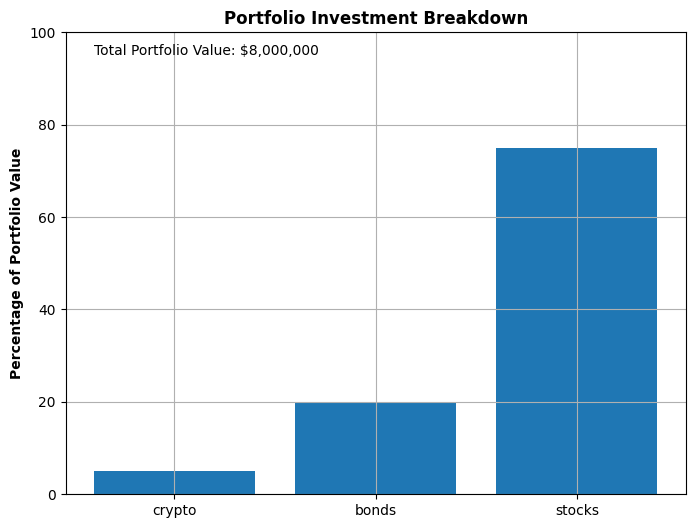

In [3]:
plt_df = investments.groupby('investment_type').sum()['initial_investment'] 
plt_df = (plt_df / investments.initial_investment.sum()) * 100
plt_df = plt_df.sort_values()

plt.figure(figsize=(8,6))
plt.bar(plt_df.index, plt_df.values)
plt.grid()
plt.ylim(0, 100)
plt.ylabel('Percentage of Portfolio Value', fontweight='bold')
plt.title('Portfolio Investment Breakdown', fontweight='bold')
plt.text(-0.4, 95, f"Total Portfolio Value: ${investments.initial_investment.sum():,}")
plt.show()

# 3. VAR Methodology 1 - Variance/Covariance

This section will focus on calculating the VAR of the portfolio using a variance/covariance approach. This approach (also known as the parametric method) is  likely the most commonly used method of calculating VAR, and assumes that the changes in risk factors across each investment in the portfolio are normally distributed. The variance/covariance approach has the benefit of taking into consideration the correlation between changes investments, and is the methodology employed by RiskMetrics in their calculations. 

## 3.1. Collect Historical Data

In order to implement this methodology, we first need to determine historical daily close prices for each of the portfolio's investments. This is done below using the `yfinance` library, and collects data for the past year (which should provide a more than adaquate sample to make a confident prediction).

In [4]:
tickers = list(investments['ticker'].values)
lookback_date = dt.date.today() - relativedelta(years=1)

close_data = pd.DataFrame()

# have to make separate dataframes because crypto markets don't close
close_data_crypto = pd.DataFrame()

for index, row in investments.iterrows():
    ticker = row['ticker']
    tmp = yf.Ticker(ticker)
    tmp = tmp.history(period="1y")['Close']
    if row['investment_type'] == 'crypto':
        close_data_crypto[ticker] = tmp
    else:
        close_data[ticker] = tmp

        
close_data = close_data.reset_index()
close_data['Date'] = pd.to_datetime(close_data['Date']).dt.date
close_data = close_data.set_index('Date')

# need to remove times since they "close" at different times
close_data_crypto = close_data_crypto.reset_index()
close_data_crypto['Date'] = pd.to_datetime(close_data_crypto['Date']).dt.date
close_data_crypto = close_data_crypto.set_index('Date')

close_data = close_data.join(close_data_crypto)
#close_data = close_data.dropna(axis=1)
close_data.head()

,XOM,PCCYF,NEE,BHP,APD,RTX,UNP,AMZN,TSLA,HESAY,...,AMX,NG,IBDRY,PLD,PSA,GOVT,BNDX,LQD,BTC-USD,ETH-USD
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,107.267914,0.350159,75.601196,46.512104,244.568161,92.532936,192.185135,102.440002,227.539993,128.499466,...,18.577469,4.63,38.820980,107.678802,298.063446,21.865227,46.975548,97.401390,20495.773438,1572.714478
2022-11-01,108.332756,0.350159,75.806053,48.243416,246.248108,93.245338,191.873184,96.790001,227.820007,132.920181,...,18.814501,4.79,38.773148,105.539810,296.033051,21.875002,46.999100,98.102196,20485.273438,1579.704590
2022-11-02,106.106270,0.368589,75.386589,46.755264,239.459961,91.879112,187.690994,92.120003,214.979996,131.539337,...,18.765120,4.45,38.227852,103.779991,272.341949,21.845680,46.940239,97.629852,20159.503906,1519.711792
2022-11-03,107.548645,0.350159,76.264542,47.008156,257.870972,92.513420,188.334396,89.300003,215.309998,126.383453,...,18.982399,4.40,37.634727,105.014786,266.231567,21.777258,46.793087,97.282829,20209.988281,1531.541748
2022-11-04,108.719971,0.368589,76.869347,51.589333,269.630554,92.923294,191.756180,90.980003,207.470001,134.718292,...,19.683622,4.87,38.208725,104.635605,267.251556,21.728388,46.763664,97.475616,21147.230469,1645.093384


As you can see in the output above, the `close_data` dataframe holds daily close data for the past year for each of the 32 items in our portfolio. 

Next, the cell below transforms those close prices into daily percentage changes, stored in the `daily_returns` dataframe:

In [5]:
daily_returns = close_data.pct_change()
daily_returns.head()

,XOM,PCCYF,NEE,BHP,APD,RTX,UNP,AMZN,TSLA,HESAY,...,AMX,NG,IBDRY,PLD,PSA,GOVT,BNDX,LQD,BTC-USD,ETH-USD
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-01,0.009927,0.000000,0.002710,0.037223,0.006869,0.007699,-0.001623,-0.055154,0.001231,0.034403,...,0.012759,0.034557,-0.001232,-0.019865,-0.006812,0.000447,0.000501,0.007195,-0.000512,0.004445
2022-11-02,-0.020552,0.052632,-0.005533,-0.030847,-0.027566,-0.014652,-0.021797,-0.048249,-0.056360,-0.010389,...,-0.002625,-0.070981,-0.014064,-0.016674,-0.080029,-0.001340,-0.001252,-0.004815,-0.015903,-0.037977
2022-11-03,0.013594,-0.050000,0.011646,0.005409,0.076886,0.006904,0.003428,-0.030612,0.001535,-0.039197,...,0.011579,-0.011236,-0.015516,0.011898,-0.022436,-0.003132,-0.003135,-0.003554,0.002504,0.007784
2022-11-04,0.010891,0.052632,0.007930,0.097455,0.045603,0.004430,0.018169,0.018813,-0.036413,0.065949,...,0.036941,0.106818,0.015252,-0.003611,0.003831,-0.002244,-0.000629,0.001982,0.046375,0.074142


## 3.2. Calculate Covariance Matrix

The cell below then calculates the covariance matrix between each of our investments by recursively comparing their daily reutrns. A visual representation of this matrix is also shown below, showing that most of the investment combinations have relatively low covariances with the exception of a few:

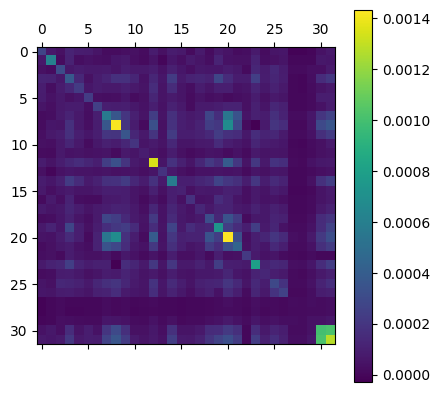

In [6]:
cov_mat = daily_returns.cov()
plt.matshow(cov_mat)
plt.colorbar()
plt.show()

## 3.3. Normal Distribution Metrics

Because the variance-covariance methodology assumes that returns of the portfolio are normally distributed, we now have to determine all the metrics needed to generate said normal distribution. First off, this requires determining the mean and standard deviation of the investment returns. To calculate the "mean" return of the entire portfolio, we can first determine the mean return of each individual investment. These means represent a vector (say $U$), which can then be combined with the weights calculated earlier (which also represent a vector, say $W$) by means of a dot product to determine the total mean return of the entire portfolio. For $n$ investments, we can then say the portfolio return mean $\mu_R$ can be calculated as follows:

$$
\begin{align}
U &= \begin{pmatrix} \mu_1 \\ \mu_2 \\ \vdots \\ \mu_n \end{pmatrix} \; ; \; 
W = \begin{pmatrix} w_1 \\ w_2 \\ \vdots \\ w_n \end{pmatrix} \\
\mu_R &= U \cdot W = \mu_1w_1 + \mu_2w_2 + ... + \mu_nw_n = \sum_{i=1}^n \mu_iw_i
\end{align}
$$

Here $\mu_1$ and $w_1$ correspond to the mean reutrn and weight of the first investment in the portfolio, respectively. The formula shown above is implemented in the cell below:

In [7]:
mu_R = daily_returns.mean()
mu_R = mu_R.dot(investments.weights.values)

We can then use $\mu_R$ to determine what the mean value of the portfolio should be at any point in the future. More specifically, the mean value of the portfolio $\mu$ after $n$ days should be: 

$$
\begin{equation}
\mu = (1 + \mu_R)^n \cdot I
\end{equation}
$$

The cell below implements this formula to solve for $\mu$ over a 1-day time period:

In [8]:
mu = (1 + mu_R) ** 1 * investments.initial_investment.sum()
mu

8005466.94165372

Based on the average rate of return, the value of the portfolio should have increased by ~5k after a single day. However, this does not yet give us an evaluation of risk or what we could expect the portfolio to lose in other than average circumstances. To do this, we must next calculate the standard deviation of the returns in the portfolio. To do this, we can weight the values in our covariance matrix using the transpose of the weights vector to get variances for each investment, and then multiply the resultant vector again by the weights vector to get a single weighted variance $\sigma^2_R$ of total portfolio. In other words: 

$$
\begin{equation}
\sigma^2_R = W^T \cdot C \cdot W
\end{equation}
$$

where $C$ represents the covariance matrix of the returns. The standard deviation $\sigma_R$ is then just the square root of $\sigma^2_R$: 

$$
\begin{equation}
\sigma_R = \sqrt{W^T \cdot C \cdot W}
\end{equation}
$$

This calculation is done in the cell below:

In [9]:
sigma_R = np.sqrt(investments.weights.values.T.dot(cov_mat).dot(investments.weights.values))

Similar to the mean, we then need to multiply $\sigma_R$ by the total inital investment to get a dollar value for the standard deviation:

In [10]:
sigma = sigma_R * investments.initial_investment.sum()
sigma

79628.82376761961

## 3.4. Calculate VAR

We now have everything we need to calculate VAR using this methodology. Using the mean and standard deviation created in the previous subsection, we can use a normal distribution to determine the maximum amount of money the portfolio stands to lose at different confidence intervals. For the purposes of this calculation, we will use a 95% confidence level. 

Using the mean, standard deviation, and confidence levels, we can then use the normal distribution to generate VAR values. 

$$
\text{VAR} = I - ( z\sigma + \mu)
$$

where $z$ is the given $z$ score of the normal distribution at the given confidence level. The 1-day VAR value for this portfolio is calculated using this formula in the cell below:

In [11]:
conf_level = 0.95

z = st.norm.ppf(1 - conf_level)
portfolio_value = z * sigma + mu
var = investments.initial_investment.sum() - portfolio_value
round(var, 2)

125510.82

In other words, we can be 95% confident that the value of the portfolio will not drop more than \$128,263.8 over the course of 1 trading day.

## 3.5. Extending the Time Period 

We can now extend the previous calculation to assess the risk over longer time periods. However, while we have already defined a way to calculate the mean used over longer time intervals, we have not yet done so for the standard deviation. Its [generally accepted that the standard deviation of stock returns tends to increase with the square root of time](https://www.investopedia.com/articles/04/101304.asp), and thus we can say that:

$$
\sigma \approx \sigma_1 \cdot \sqrt{n}
$$

where $\sigma_1$ is the day one standard deviation. 

Now that we have a way to calculate all the necessary variables at any point in time, the cell below defines a function `var_cov_VAR()` that can be used to replicate the entire process shown above, and then calculate VAR for a range of days into the future. 

In [12]:
def collect_close_data(tickers, types, lookback_months):
    
    close_data = pd.DataFrame()
    close_data_crypto = pd.DataFrame()
    i = 0
    for ticker in tickers:

        tmp = yf.Ticker(ticker)
        tmp = tmp.history(period=f"{lookback_months}mo")['Close']
        if types[i] == 'crypto':
            close_data_crypto[ticker] = tmp
        else:
            close_data[ticker] = tmp
        i += 1


    close_data = close_data.reset_index()
    close_data['Date'] = pd.to_datetime(close_data['Date']).dt.date
    close_data = close_data.set_index('Date')
    close_data_crypto = close_data_crypto.reset_index()
    close_data_crypto['Date'] = pd.to_datetime(close_data_crypto['Date']).dt.date
    close_data_crypto = close_data_crypto.set_index('Date')
    close_data = close_data.join(close_data_crypto)
    return close_data

def get_return_metrics(close_data, weights):
    
    # transform into returns 
    daily_returns = close_data.pct_change()

    # determine covariance matrix
    cov_mat = daily_returns.cov()
    
    # get mean and standard deviations (returns)
    mu_R = daily_returns.mean()
    mu_R = mu_R.dot(weights)
    sigma_R = np.sqrt(weights.T.dot(cov_mat).dot(weights))
    return (mu_R, sigma_R)


def calc_VAR(mu_R, sigma_R, investment, conf, n):
        
        mu = (1 + mu_R) ** 1 * investment
        sigma = sigma_R * investment * np.sqrt(n)
        z = st.norm.ppf(1 - conf)
        portfolio_value = z * sigma + mu
        var = investment - portfolio_value
        return var

def var_cov_VAR(tickers, types, weights, investment, lookback_months, conf, start=1, stop=1):
    '''
    tickers: A list of ticker symbols, as they appear in yahoo finance (yfinance library).
    types: A list of the investment types (should be one of 'crypto', 'stocks', or 'bonds')
    weights: Relative weights of each investment.
    lookback_months: How many months of historical data used in VAR calculation
    conf: The confidence level used in the VAR calculation.
    start: The start of the range (in trading days) over which to perform the VAR calculation.
    stop: The end of the range (in trading days) over which to perform the VAR calculation.
    
    Returns a two column dataframe that of VAR values calculated via a variance/covariance
    methodology for all trading days within the provided start and stop range.
    '''
    
    print('getting data from yahoo finance...')
    close_data = collect_close_data(tickers, types, lookback_months)
    print('calculating return metrics')
    mu_R, sigma_R = get_return_metrics(close_data, weights)
    
    print('calculating VAR values...')
    var_vals = []
    for i in range(start, stop):
        var = calc_VAR(mu_R, sigma_R, investment, conf, i)
        var_vals.append([i, var])
    
    print('Done!')
    return pd.DataFrame(var_vals, columns=['trading_days', 'var_estimate'])


The cells below uses this function to determine the VAR over the course of an entire trading year at different confidence levels, and plots the results:

In [13]:
var99_df = var_cov_VAR(investments.ticker, investments.investment_type, investments.weights.values, 
                     investments.initial_investment.sum(), 12, 0.99, 1, 252)
var95_df = var_cov_VAR(investments.ticker, investments.investment_type, investments.weights.values, 
                     investments.initial_investment.sum(), 12, 0.95, 1, 252)
var80_df = var_cov_VAR(investments.ticker, investments.investment_type, investments.weights.values, 
                     investments.initial_investment.sum(), 12, 0.8, 1, 252)

getting data from yahoo finance...
calculating return metrics
calculating VAR values...
Done!
getting data from yahoo finance...
calculating return metrics
calculating VAR values...
Done!
getting data from yahoo finance...
calculating return metrics
calculating VAR values...
Done!


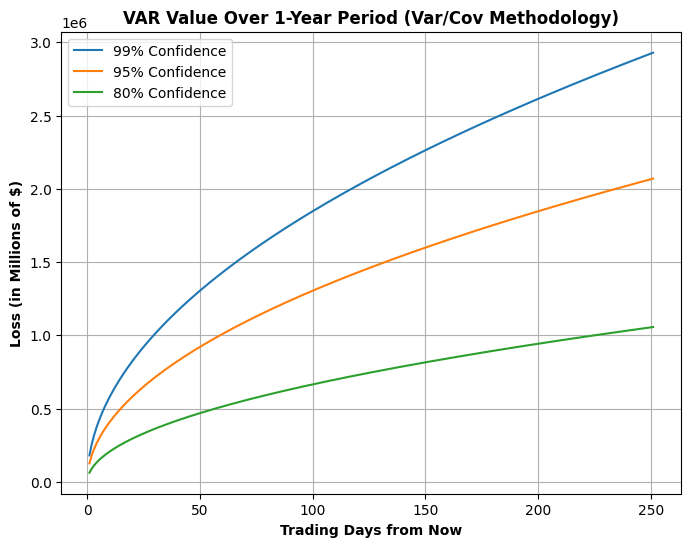

In [14]:
plt.figure(figsize=(8,6))

plt.plot(var99_df.trading_days, var99_df.var_estimate, label='99% Confidence')
plt.plot(var95_df.trading_days, var95_df.var_estimate, label='95% Confidence')
plt.plot(var80_df.trading_days, var80_df.var_estimate, label='80% Confidence')
plt.grid()
plt.title('VAR Value Over 1-Year Period (Var/Cov Methodology)', fontweight='bold')
plt.xlabel('Trading Days from Now', fontweight='bold')
plt.ylabel('Loss (in Millions of $)', fontweight='bold')
plt.legend()
plt.show()

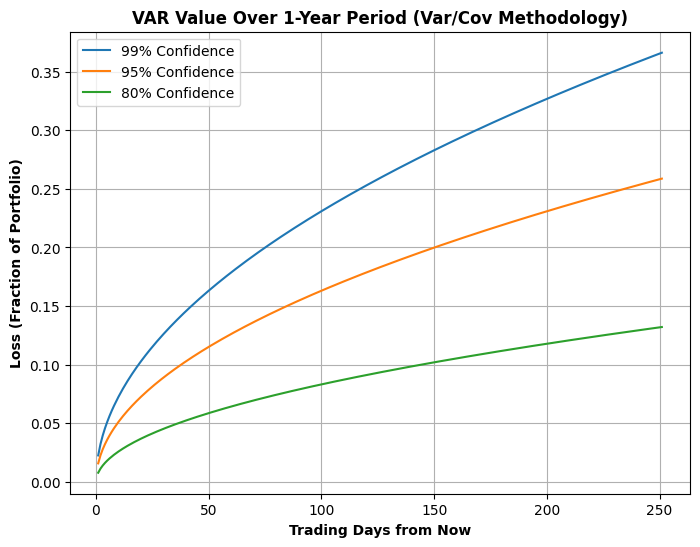

In [15]:
plt.figure(figsize=(8,6))

plt.plot(var99_df.trading_days, var99_df.var_estimate / investments.initial_investment.sum(), label='99% Confidence')
plt.plot(var95_df.trading_days, var95_df.var_estimate / investments.initial_investment.sum(), label='95% Confidence')
plt.plot(var80_df.trading_days, var80_df.var_estimate / investments.initial_investment.sum(), label='80% Confidence')
plt.grid()
plt.title('VAR Value Over 1-Year Period (Var/Cov Methodology)', fontweight='bold')
plt.xlabel('Trading Days from Now', fontweight='bold')
plt.ylabel('Loss (Fraction of Portfolio)', fontweight='bold')
plt.legend()
plt.show()

Thus, in summary we can be:

* 80% sure that the portfolio will not lose more than ~12% of its value,
* 95% sure that the portfolio will not lose more than ~26% of its value,
* 99% sure that the portfolio will not lose more than ~37% of its value.

# 4. Monte Carlo Methodology

This section will perform another VAR calculation, this time using a Monte Carlo simulation methodology. The process employed by this specific Monte Carlo process carries out the following steps:

1. Determine the total shares (units) invested in each asset using the intial investments from the `investments` dataframe and the latest close prices from the `close_data` dataframe.
2. Using the `daily_returns` dataframe, randomly select $n$ previously occuring daily return rates for each asset, where $n$ is the number of trading days into the future for when you are performing the VAR analysis.
3. Multiply together the randomly selected return rates for each asset from the previous step, in essence creating a prediction of the return rate for each asset $n$ days into the future. 
4. Multiply the predicted return rates by the latest close values, creating a prediciton of the value of a single unit of each asset $n$ days into the future.
5. Multiply the unit values determined in step 4 by the number of shares (units) calculated in step 1. Sum these values together to get a prediction of the portfolio value $n$ days into the future.
6. Repeat steps 2-5 for a given number of simulations, so that you have an array of predicted portfolio values.
7. Calculate the mean and standard deviation of the predictions in step 6.
8. Use the calculated mean and standard deviation in conjunction with a normal distribution and predetermined confidence level to calculate the final VAR value.

## 4.1. Test Simulation

These steps are carried out and labelled below in order to calculate the 1 day VAR.

In [16]:
conf_level = 0.95
num_simulations = 1000

# step 1
current_prices = close_data.iloc[-1]
initial_investments = pd.Series(investments.initial_investment.values, index = current_prices.index)
shares = initial_investments.divide(current_prices)


portfolio_predictions = []
for i in range(num_simulations): # step 6 
    combined_returns = []
    for (col_name, col_data) in daily_returns.iteritems():
        # step 2
        col_returns = col_data[~np.isnan(col_data)]
        combined_return = np.prod(1 + np.random.choice(col_returns, size=1, replace=True))
        combined_returns.append(combined_return)
        
    # step 3
    combined_returns = pd.Series(combined_returns, index = current_prices.index)
    share_prediction = current_prices.multiply(combined_returns) 
    
    # step 4
    predictions = share_prediction.multiply(shares)
    
    # step 5
    portfolio_prediction = predictions.sum()
    portfolio_predictions.append(portfolio_prediction)

# step 7
portfolio_predictions = np.array(portfolio_predictions)
mu = portfolio_predictions.mean()
sigma = portfolio_predictions.std()

# step 8
z = st.norm.ppf(1 - conf_level)
portfolio_value = z * sigma + mu
var = investments.initial_investment.sum() - portfolio_value
round(var, 2)

52581.57

Thus, the VAR produced by this methodology tells us that we can be 95% confident that the value of our portfolio will not lose more than ~$55,000 in the first day.

Because this VAR calculation also relies on the fact that the predicitons of the final portfolio values are normally distributed, the figure below first checks to make sure that this is indeed the case:

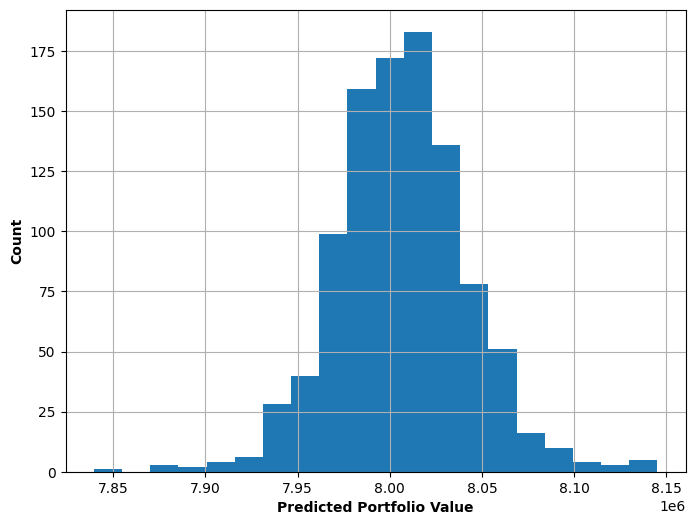

In [17]:
plt.figure(figsize=(8,6))

plt.hist(portfolio_predictions, bins=20)
plt.grid()
plt.ylabel('Count', fontweight='bold')
plt.xlabel('Predicted Portfolio Value', fontweight='bold')
plt.show()

The plot above shows that these predicted portfolio values are indeed normally distributed!

## Extending the Time Period 

The cell below creates a function `monte_carlo_VAR` that performs this Monte Carlo simulation, so that it can be easily replicated to calculate VAR values at different confidences and points in time.

In [18]:
def monte_carlo_VAR(tickers, types, investments, lookback_months, conf, num_sims, days_list):
    '''
    tickers: A list of ticker symbols, as they appear in yahoo finance (yfinance library).
    types: A list of the investment types (should be one of 'crypto', 'stocks', or 'bonds')
    investments: The dollar amount of the investment in each asset.
    lookback_months: How many months of historical data used in VAR calculation.
    conf: The confidence level used in the VAR calculation.
    num_sims: The number of simulations used to empirically estimate the VAR (should be >= 100).
    days_list: A list of the number of days for which you would like to perform the VAR calculation.
    
    Returns a two column dataframe that of VAR values calculated via a Monte Carlo simulation
    methodology for all trading days within the provided start and stop range.
    '''
    
    print('getting data from yahoo finance...')
    close_data = collect_close_data(tickers, types, lookback_months)
    
    print('get amount of shares (units) of each asset in portfolio...')
    current_prices = close_data.iloc[-1]
    initial_investments = pd.Series(investments.values, index = current_prices.index)
    shares = initial_investments.divide(current_prices)

    
    var_vals = []
    print('calc VAR values...')
    for days in days_list:
        portfolio_predictions = []
        for i in range(num_sims):
            combined_returns = []
            for (col_name, col_data) in daily_returns.iteritems():
                col_returns = col_data[~np.isnan(col_data)]
                combined_return = np.prod(1 + np.random.choice(col_returns, size=days, replace=True))
                combined_returns.append(combined_return)

            combined_returns = pd.Series(combined_returns, index = current_prices.index)
            share_prediction = current_prices.multiply(combined_returns) 

            predictions = share_prediction.multiply(shares)
            portfolio_prediction = predictions.sum()
            portfolio_predictions.append(portfolio_prediction)

        portfolio_predictions = np.array(portfolio_predictions)

        mu = portfolio_predictions.mean()
        sigma = portfolio_predictions.std()
        z = st.norm.ppf(1 - conf)
        portfolio_value = z * sigma + mu
        var = investments.sum() - portfolio_value
        var_vals.append([days, var])

    return pd.DataFrame(var_vals, columns=['trading_days', 'var_estimate'])

In [19]:
var99_df = monte_carlo_VAR(investments.ticker, investments.investment_type, investments.initial_investment,
                           12, 0.99, 1000, [1, 50, 100, 150, 200, 250])
var95_df = monte_carlo_VAR(investments.ticker, investments.investment_type, investments.initial_investment,
                           12, 0.95, 1000, [1, 50, 100, 150, 200, 250])
var80_df = monte_carlo_VAR(investments.ticker, investments.investment_type, investments.initial_investment,
                           12, 0.80, 1000, [1, 50, 100, 150, 200, 250])

getting data from yahoo finance...
get amount of shares (units) of each asset in portfolio...
calc VAR values...
getting data from yahoo finance...
get amount of shares (units) of each asset in portfolio...
calc VAR values...
getting data from yahoo finance...
get amount of shares (units) of each asset in portfolio...
calc VAR values...


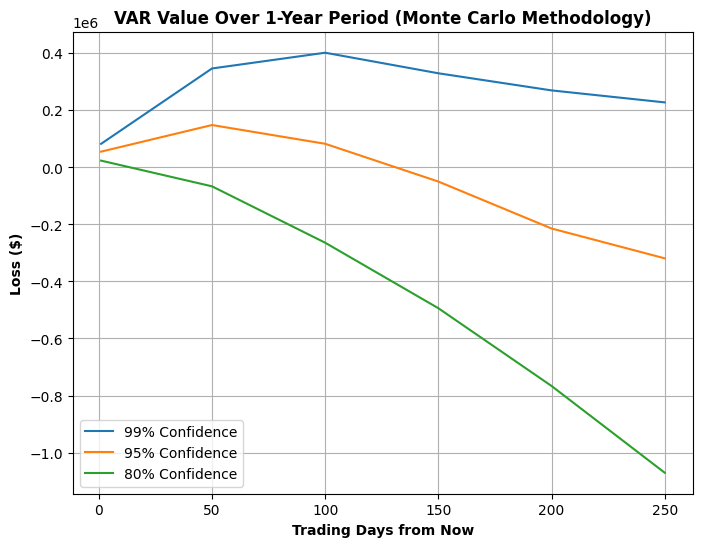

In [20]:
plt.figure(figsize=(8,6))

plt.plot(var99_df.trading_days, var99_df.var_estimate, label='99% Confidence')
plt.plot(var95_df.trading_days, var95_df.var_estimate, label='95% Confidence')
plt.plot(var80_df.trading_days, var80_df.var_estimate, label='80% Confidence')
plt.grid()
plt.title('VAR Value Over 1-Year Period (Monte Carlo Methodology)', fontweight='bold')
plt.xlabel('Trading Days from Now', fontweight='bold')
plt.ylabel('Loss ($)', fontweight='bold')
plt.legend()
plt.show()

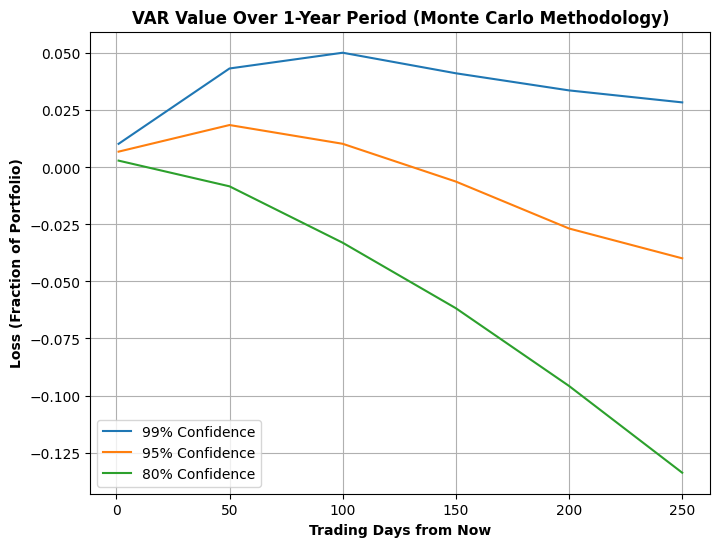

In [21]:
plt.figure(figsize=(8,6))

plt.plot(var99_df.trading_days, var99_df.var_estimate / investments.initial_investment.sum(), label='99% Confidence')
plt.plot(var95_df.trading_days, var95_df.var_estimate / investments.initial_investment.sum(), label='95% Confidence')
plt.plot(var80_df.trading_days, var80_df.var_estimate / investments.initial_investment.sum(), label='80% Confidence')
plt.grid()
plt.title('VAR Value Over 1-Year Period (Monte Carlo Methodology)', fontweight='bold')
plt.xlabel('Trading Days from Now', fontweight='bold')
plt.ylabel('Loss (Fraction of Portfolio)', fontweight='bold')
plt.legend()
plt.show()

# 5. Conclusion 

Based on the above results, the variance/covariance methodology defintiely resulted in VAR values that seem more trustworthy. While we were able to generate results using the Monte Carlo simulation method, there likely needs to be some rethinking into how the VAR values are actually calculated, as obtaining negative values like the ones in the plot above is not realistic. Next steps: fix it!